Posterior Mean of a (slope): 1.8284571365324638
Posterior Mean of b (intercept): 334.1269869445382
Posterior Covariance Matrix:
 [[ 1.38240460e-05 -2.88000909e-04]
 [-2.88000909e-04  8.00001754e-03]]


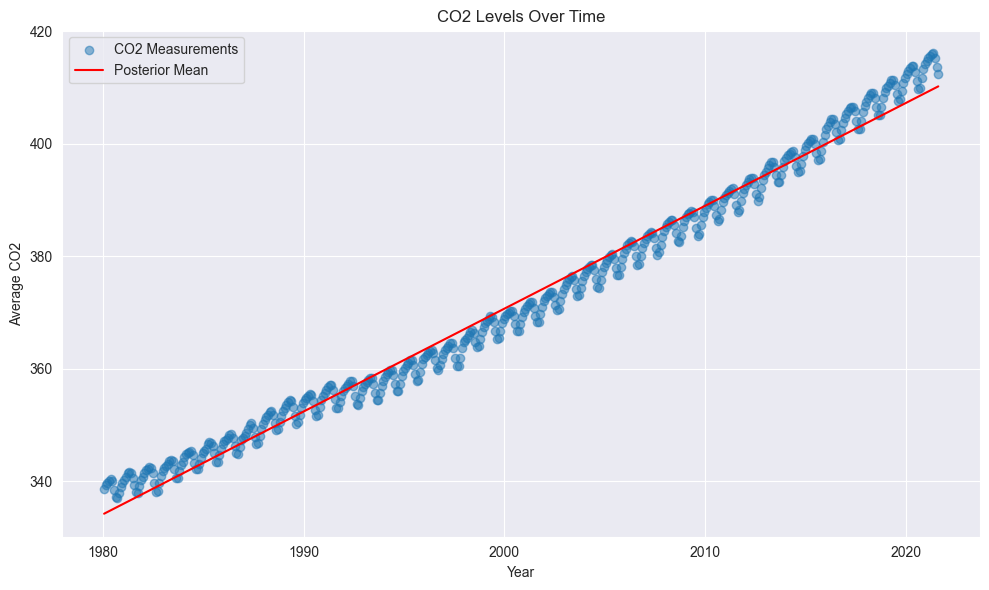

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
DATA_FILE = 'co2.txt'
BASE_YEAR = 1980.0  # Base year for adjusting the time variable

# Prior Parameters
PRIOR_MEAN = np.array([0.0, 360.0])  # [a, b]
PRIOR_COVARIANCE = np.diag([10.0**2, 100.0**2])  # Covariance matrix
PRIOR_COV_INV = np.linalg.inv(PRIOR_COVARIANCE)

# Initialize lists to store time and CO2 measurements
time = []
co2_average = []

# Load data from the file
try:
    with open(DATA_FILE, 'r') as file:
        for line in file:
            line = line.strip()

            # Skip comment lines and empty lines
            if line.startswith('#') or not line:
                continue

            # Split the line into columns
            columns = line.split()

            # Ensure there are at least 5 columns
            if len(columns) >= 5:
                try:
                    decimal_year = float(columns[2])
                    average_co2 = float(columns[3])

                    # Adjust time relative to the base year
                    adjusted_time = decimal_year - BASE_YEAR
                    time.append(adjusted_time)
                    co2_average.append(average_co2)
                except ValueError:
                    # Handle lines with non-numeric data
                    continue
except FileNotFoundError:
    raise FileNotFoundError(f"The file {DATA_FILE} was not found.")

# Convert lists to NumPy arrays for efficient computations
t = np.array(time)  # Time variable (years since BASE_YEAR)
y = np.array(co2_average)  # Average CO2 measurements

# Design Matrix Construction
# Each row corresponds to [t_i, 1] representing the linear model coefficients
X = np.column_stack((t, np.ones_like(t)))

# Posterior Covariance Calculation
# Σ_post = (Σ_prior^{-1} + X^T X)^{-1}
posterior_cov_inv = PRIOR_COV_INV + X.T @ X
posterior_covariance = np.linalg.inv(posterior_cov_inv)

# Posterior Mean Calculation
# μ_post = Σ_post (Σ_prior^{-1} μ_prior + X^T y)
posterior_mean = posterior_covariance @ (PRIOR_COV_INV @ PRIOR_MEAN + X.T @ y)

# Extract posterior estimates for parameters a and b
a_posterior, b_posterior = posterior_mean

# Display the results
print("Posterior Mean of a (slope):", a_posterior)
print("Posterior Mean of b (intercept):", b_posterior)
print("Posterior Covariance Matrix:\n", posterior_covariance)

# Optional: Visualization of the Data and Posterior Mean Line
plt.figure(figsize=(10, 6))
plt.scatter(t + BASE_YEAR, y, label='CO2 Measurements', alpha=0.5)
plt.plot(t + BASE_YEAR, a_posterior * t + b_posterior, color='red', label='Posterior Mean')
plt.xlabel('Year')
plt.ylabel('Average CO2')
plt.title('CO2 Levels Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


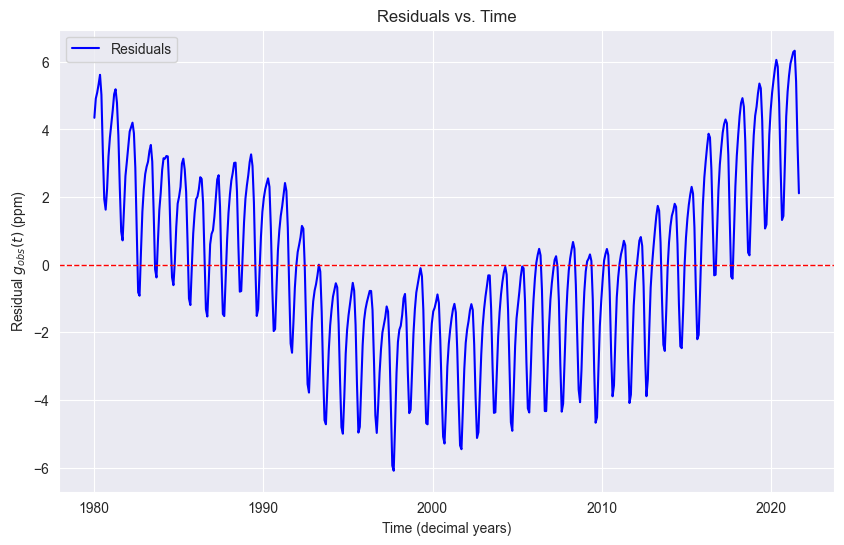

Mean of residuals: -0.0000
Variance of residuals: 7.1881
Shapiro-Wilk test statistic: 0.9891, p-value: 0.0009


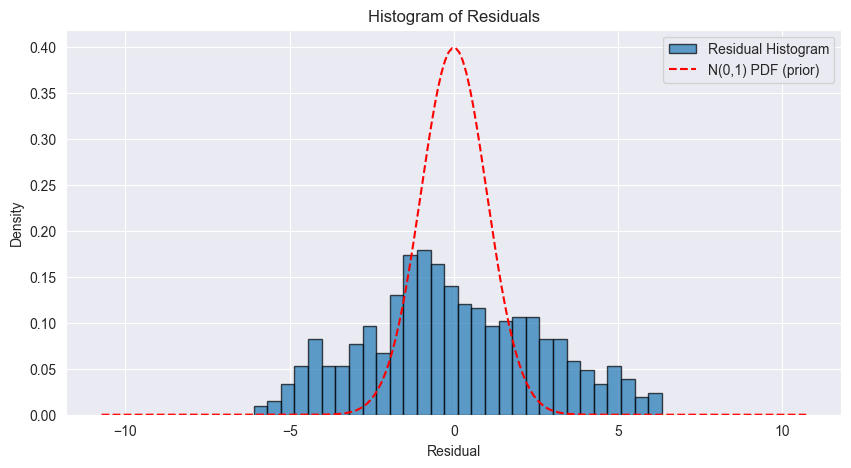

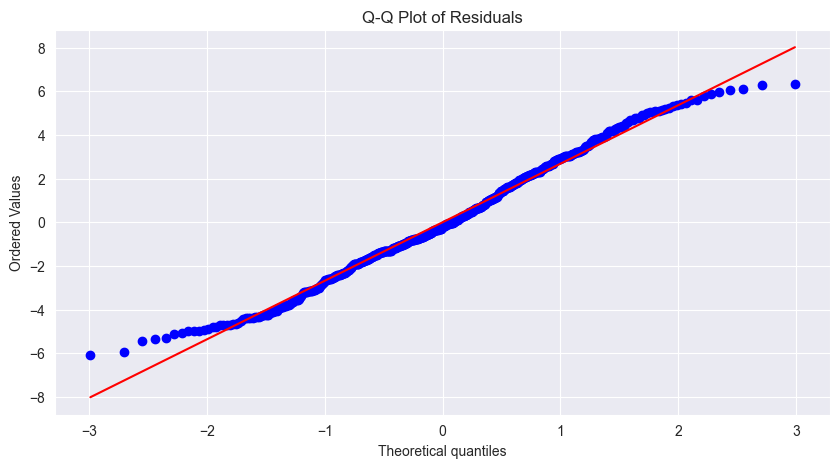

In [3]:
import scipy.stats as stats

# Assumptions for previous code:
# t: numpy array of shape (N,) containing times (decimal years)
# y: numpy array of shape (N,) containing observed CO2 concentrations (fobs(t))
# a_posterior, b_posterior: scalars for MAP estimates of a and b, obtained from previous steps

# Compute residuals: gobs(t) = fobs(t) - (a_posterior * t + b_posterior)
gobs = y - (a_posterior * t + b_posterior)

# Plot residuals against time as a line plot
plt.figure(figsize=(10, 6))
plt.plot(t + 1980, gobs, label='Residuals', color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Time (decimal years)')
plt.ylabel('Residual $g_{obs}(t)$ (ppm)')
plt.title('Residuals vs. Time')
plt.legend()
plt.grid(True)
plt.savefig(fname="2b1.png", dpi=300)
plt.show()

# Print mean and variance of residuals
mean_res = np.mean(gobs)
var_res = np.var(gobs, ddof=1)  # sample variance
print(f"Mean of residuals: {mean_res:.4f}")
print(f"Variance of residuals: {var_res:.4f}")

# Test normality (e.g., Shapiro-Wilk test)
shapiro_stat, shapiro_p = stats.shapiro(gobs)
print(f"Shapiro-Wilk test statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")

# Plot histogram of residuals and compare to a standard normal PDF
plt.figure(figsize=(10, 5))
plt.hist(gobs, bins=30, density=True, alpha=0.7, edgecolor='black', label='Residual Histogram')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')

# Plot a standard normal PDF to reflect the prior belief ε(t) ~ N(0,1)
xvals = np.linspace(mean_res - 4*np.sqrt(var_res), mean_res + 4*np.sqrt(var_res), 200)
normal_pdf = stats.norm.pdf(xvals, loc=0, scale=1)  # N(0,1)
plt.plot(xvals, normal_pdf, 'r--', label='N(0,1) PDF (prior)')
plt.legend()
plt.grid(True)
plt.savefig(fname="2b2.png", dpi=300)
plt.show()

# Q-Q plot to check normality
plt.figure(figsize=(10,5))
stats.probplot(gobs, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.savefig(fname="2b3.png", dpi=300)
plt.show()


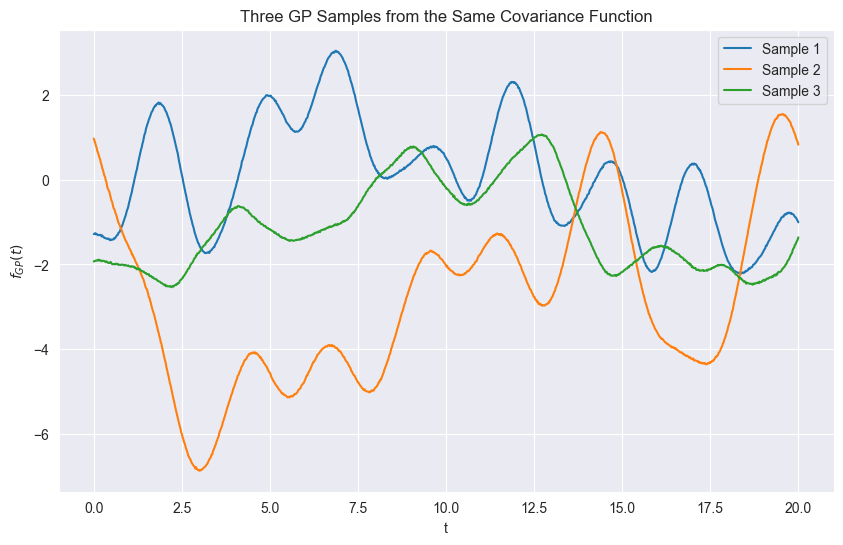

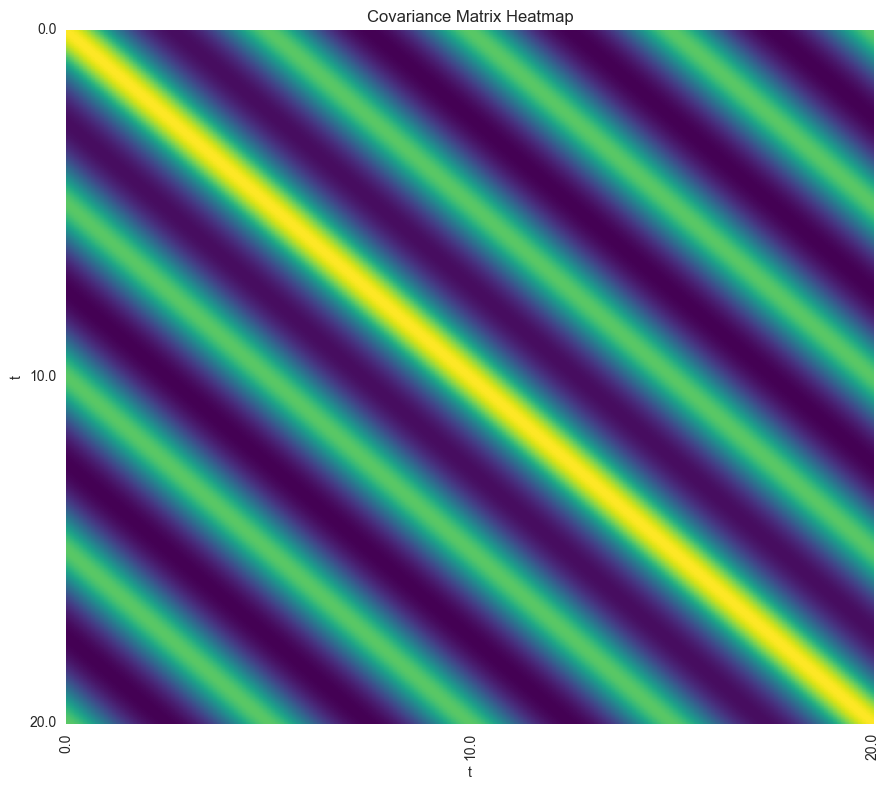

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random
import numpy as np

jax.config.update("jax_enable_x64", True)

def kernel(x1, x2, theta, tau, sigma, phi, eta, zeta):
    """
    Combined periodic and squared exponential kernel with noise:
    k(s,t) = theta^2[exp(-2 sin^2(pi(s-t)/tau)/sigma^2) + phi^2 exp(-((s-t)^2)/(2 eta^2))] + zeta^2 delta_{s=t}.
    """
    pi = jnp.pi
    dist = pi * (x1[:, None] - x2[None, :]) / tau

    # Periodic component
    periodic_part = theta**2 * jnp.exp(-2.0 * (jnp.sin(dist))**2 / sigma**2)
    # RBF component (with theta^2 and phi^2)
    se_part = (theta**2 * phi**2) * jnp.exp(-((x1[:, None] - x2[None, :])**2) / (2 * eta**2))

    # Noise on the diagonal if x1 == x2
    same_input = (x1.shape == x2.shape) and jnp.all(x1 == x2)
    noise_part = jnp.where(
        same_input,
        zeta**2 * jnp.eye(len(x1)),
        jnp.zeros((len(x1), len(x2)))
    )

    return periodic_part + se_part + noise_part

@jax.jit
def compute_covariance_matrix(x, params):
    theta, tau, sigma, phi, eta, zeta = params
    K = kernel(x, x, theta, tau, sigma, phi, eta, zeta)
    return K

@jax.jit
def gp_sample(key, x, K):
    """
    Draw a function sample from a GP with mean zero and covariance K.
    This function returns one sample vector f ~ N(0, K).
    """
    N = len(x)
    mean = jnp.zeros(N)
    # Add a small jitter for numerical stability in Cholesky
    L = jnp.linalg.cholesky(K + 1e-9 * jnp.eye(N))
    eps = random.normal(key, shape=(N,))
    return mean + L @ eps

# Let's choose a particular set of parameters
theta_default = 2.5
tau_default   = 5
sigma_default = 1.26
phi_default   = 0.5
eta_default   = 1.26
zeta_default  = 0.01

params = (theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default)

# Define input points
t = jnp.linspace(0, 20, 1000)

# Compute covariance matrix
K = compute_covariance_matrix(t, params)

# Generate three samples from the GP
key = random.PRNGKey(42)
key1, key2, key3 = random.split(key, 3)
f_sample1 = gp_sample(key1, t, K)
f_sample2 = gp_sample(key2, t, K)
f_sample3 = gp_sample(key3, t, K)

# Plot the three samples on the same figure
plt.figure(figsize=(10,6))
plt.plot(t, f_sample1, label='Sample 1')
plt.plot(t, f_sample2, label='Sample 2')
plt.plot(t, f_sample3, label='Sample 3')
plt.title("Three GP Samples from the Same Covariance Function")
plt.xlabel("t")
plt.ylabel("$f_{GP}(t)$")
plt.legend()
plt.grid(True)
plt.savefig("2cd1.png", dpi=300)
plt.show()

# Plot the Gram matrix as a heatmap with t values on axes
K_np = np.array(K)
plt.figure(figsize=(9,8))

# Create a seaborn heatmap
ax = sns.heatmap(K_np, cmap='viridis', cbar=False)

# Define tick positions
tick_positions = [0, 500, 999]
tick_labels = [f"{t[0]:.1f}", f"{t[500]:.1f}", f"{t[-1]:.1f}"]

# Set x and y ticks
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

plt.title("Covariance Matrix Heatmap")
plt.xlabel("t")
plt.ylabel("t")
plt.tight_layout()
plt.savefig("2cd2.png", dpi=300)
plt.show()


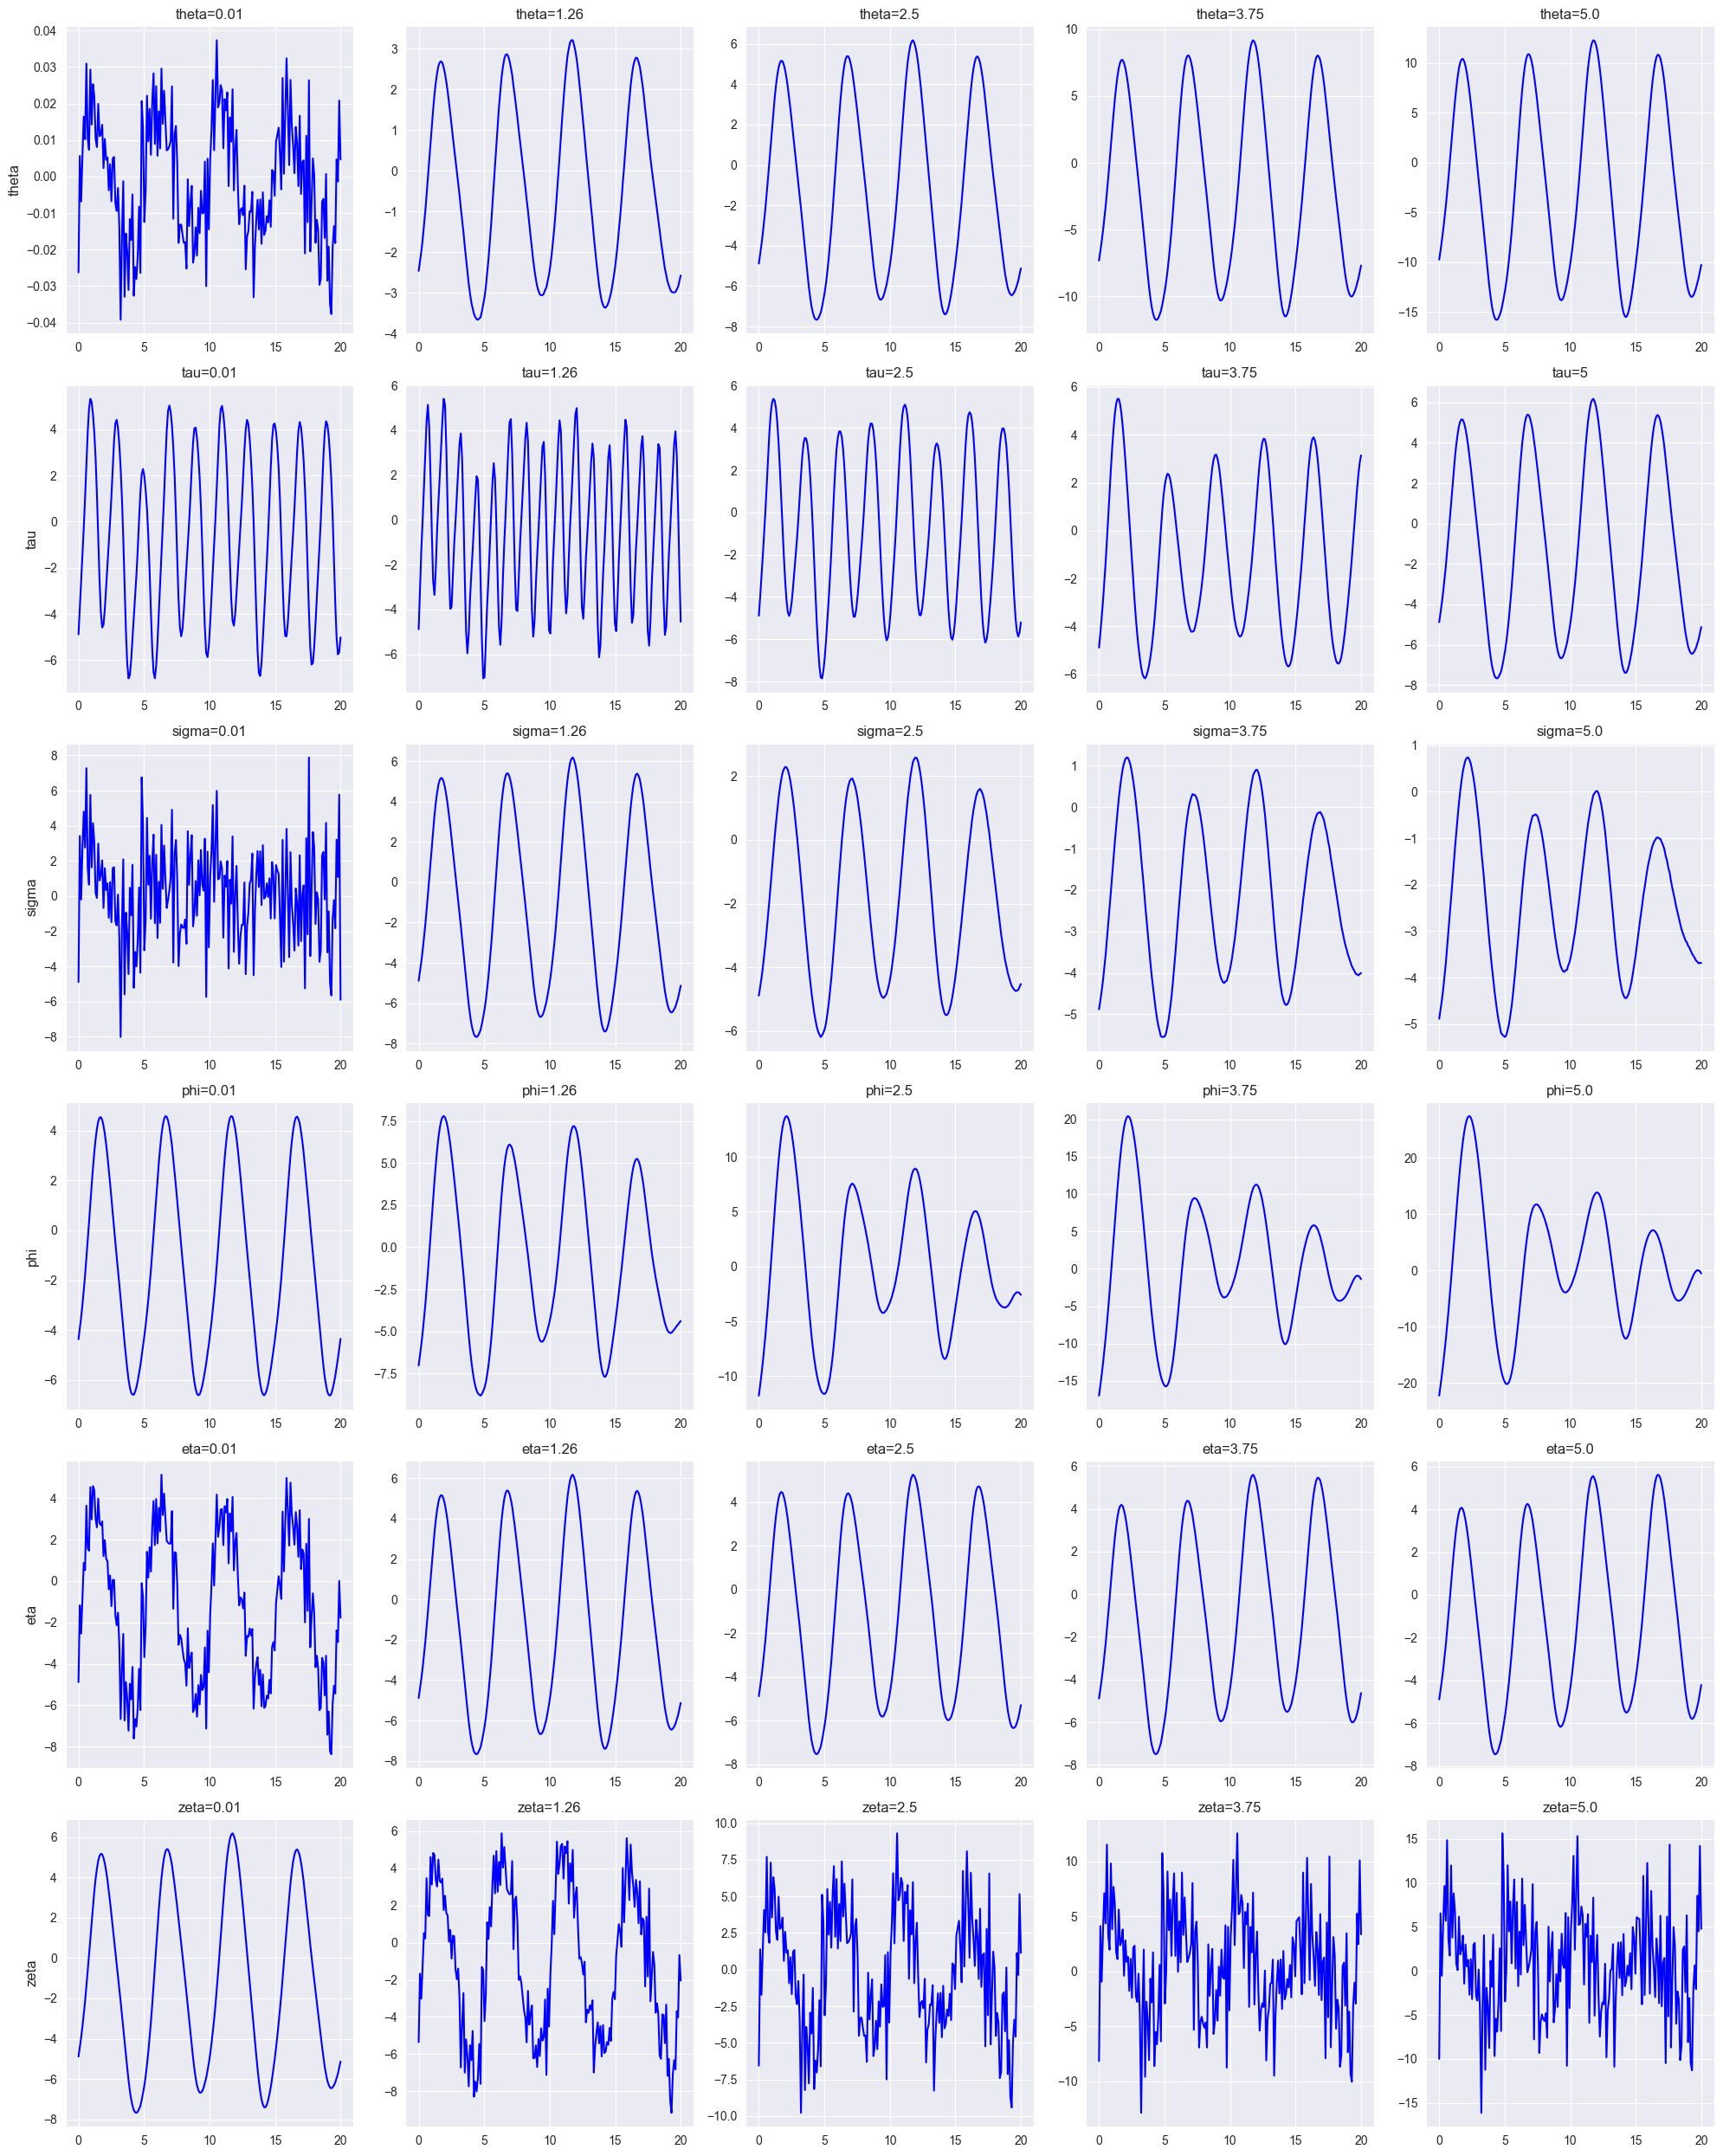

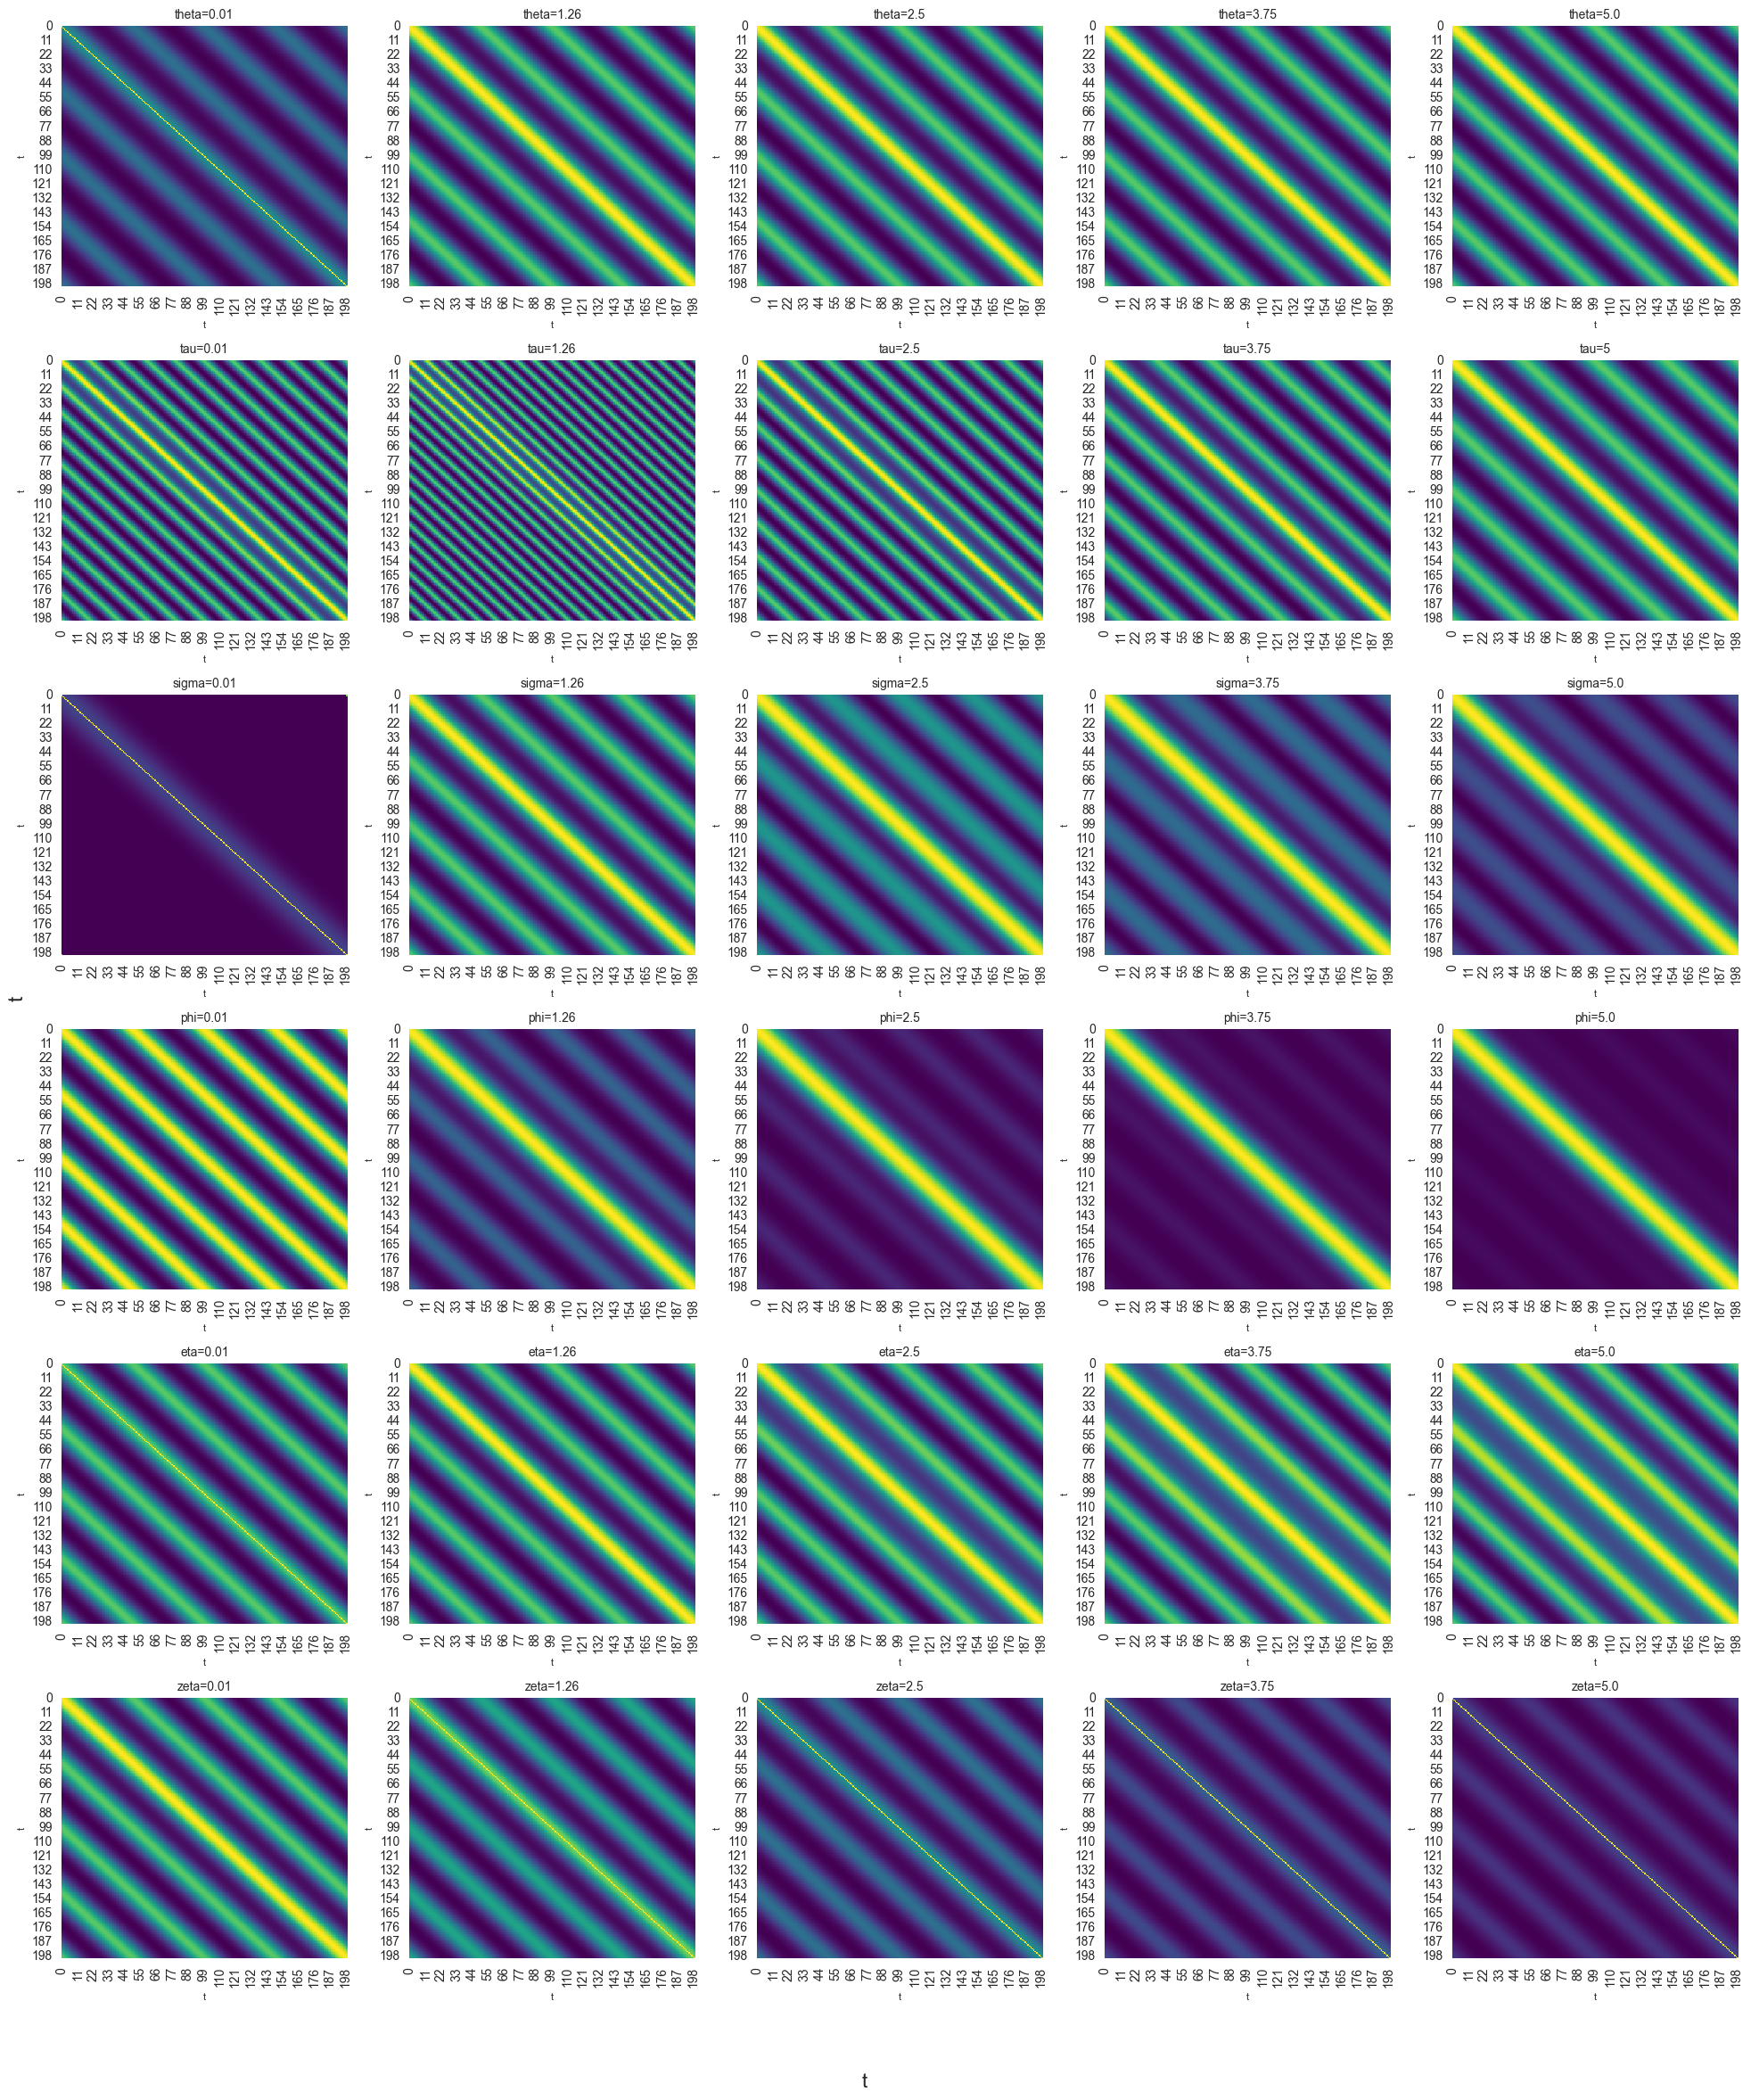

In [4]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random
import numpy as np

# Enable 64-bit precision
jax.config.update("jax_enable_x64", True)

def kernel(x1, x2, theta, tau, sigma, phi, eta, zeta):
    """
    Combined periodic and squared exponential kernel with noise.
    """
    pi = jnp.pi
    dist = pi * (x1[:, None] - x2[None, :]) / tau
    periodic_part = theta**2 * jnp.exp(-2.0 * (jnp.sin(dist))**2 / sigma**2)
    se_part = (theta**2 * phi**2) * jnp.exp(-((x1[:, None] - x2[None, :])**2) / (2 * eta**2))

    # Add noise only if x1 and x2 are the same
    same_input = (x1.shape == x2.shape) and jnp.all(x1 == x2)
    noise_part = jnp.where(
        same_input,
        zeta**2 * jnp.eye(len(x1)),
        jnp.zeros((len(x1), len(x2)))
    )

    return periodic_part + se_part + noise_part

@jax.jit
def compute_covariance_matrix(x, params):
    theta, tau, sigma, phi, eta, zeta = params
    K = kernel(x, x, theta, tau, sigma, phi, eta, zeta)
    return K

@jax.jit
def gp_sample(key, x, K):
    """
    Draw a function sample from a GP with mean zero and covariance K.
    This function returns one sample vector f ~ N(0, K).
    """
    N = len(x)
    mean = jnp.zeros(N)
    L = jnp.linalg.cholesky(K + 1e-6 * jnp.eye(N))  # Add jitter for numerical stability
    eps = random.normal(key, shape=(N,))
    return mean + L @ eps

# Define input points
x = jnp.linspace(0, 20, 200)

# Parameter values
theta_values = [0.01, 1.26, 2.5, 3.75, 5.0]
tau_values   = [0.01, 1.26, 2.5, 3.75, 5]
sigma_values = [0.01, 1.26, 2.5, 3.75, 5.0]
phi_values   = [0.01, 1.26, 2.5, 3.75, 5.0]
eta_values   = [0.01, 1.26, 2.5, 3.75, 5.0]
zeta_values  = [0.01, 1.26, 2.5, 3.75, 5.0]

# Default values for parameters
theta_default = 2.5
tau_default   = 5
sigma_default = 1.26
phi_default   = 0.5
eta_default   = 1.26
zeta_default  = 0.01

# Define parameter sweeps: Each row sweeps one parameter
param_sweeps = [
    ("theta", theta_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
    ("tau", tau_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
    ("sigma", sigma_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
    ("phi", phi_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
    ("eta", eta_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
    ("zeta", zeta_values, theta_default, tau_default, sigma_default, phi_default, eta_default, zeta_default),
]


key = random.PRNGKey(42)

### Figure for GP samples ###
fig_samples, axes_samples = plt.subplots(len(param_sweeps), 5, figsize=(20, 25), sharex=False, sharey=False)

for row_idx, (param_name, values, th, ta, si, ph, et, ze) in enumerate(param_sweeps):
    for col_idx, val in enumerate(values):
        # Depending on which parameter we vary, set that param to val
        if param_name == "theta":
            params = (val, ta, si, ph, et, ze)
        elif param_name == "tau":
            params = (th, val, si, ph, et, ze)
        elif param_name == "sigma":
            params = (th, ta, val, ph, et, ze)
        elif param_name == "phi":
            params = (th, ta, si, val, et, ze)
        elif param_name == "eta":
            params = (th, ta, si, ph, val, ze)
        elif param_name == "zeta":
            params = (th, ta, si, ph, et, val)
        else:
            raise ValueError(f"Unknown parameter: {param_name}")

        K = compute_covariance_matrix(x, params)
        f_sample = gp_sample(key, x, K)
        ax = axes_samples[row_idx, col_idx]
        ax.plot(x, f_sample, color='blue')
        ax.set_title(f"{param_name}={val}")
        ax.grid(True)

    # Label the first column with the parameter name
    axes_samples[row_idx, 0].set_ylabel(param_name, fontsize=12)

fig_samples.tight_layout()
fig_samples.savefig("2cd3.png", dpi=300)
plt.show()


### Figure for covariance matrices ###
fig_cov, axes_cov = plt.subplots(len(param_sweeps), 5, figsize=(20, 25))

for row_idx, (param_name, values, th, ta, si, ph, et, ze) in enumerate(param_sweeps):
    for col_idx, val in enumerate(values):
        # Depending on which parameter we vary, set that param to val
        if param_name == "theta":
            params = (val, ta, si, ph, et, ze)
        elif param_name == "tau":
            params = (th, val, si, ph, et, ze)
        elif param_name == "sigma":
            params = (th, ta, val, ph, et, ze)
        elif param_name == "phi":
            params = (th, ta, si, val, et, ze)
        elif param_name == "eta":
            params = (th, ta, si, ph, val, ze)
        elif param_name == "zeta":
            params = (th, ta, si, ph, et, val)
        else:
            raise ValueError(f"Unknown parameter: {param_name}")

        K = compute_covariance_matrix(x, params)
        K_np = np.array(K)
        ax = axes_cov[row_idx, col_idx]
        sns.heatmap(K_np, cmap='viridis', ax=ax, cbar=False)

        # Set the title for each subplot
        ax.set_title(f"{param_name}={val}", fontsize=10)

        # Set common axis labels 't' and adjust tick marks
        ax.set_xlabel('t', fontsize=8)
        ax.set_ylabel('t', fontsize=8)


# Add common x and y labels for the entire figure
fig_cov.supxlabel('t', fontsize=16)
fig_cov.supylabel('t', fontsize=16)

# Adjust layout to prevent overlap
fig_cov.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and display the figure
fig_cov.savefig("2cd4.png", dpi=300)
plt.show()

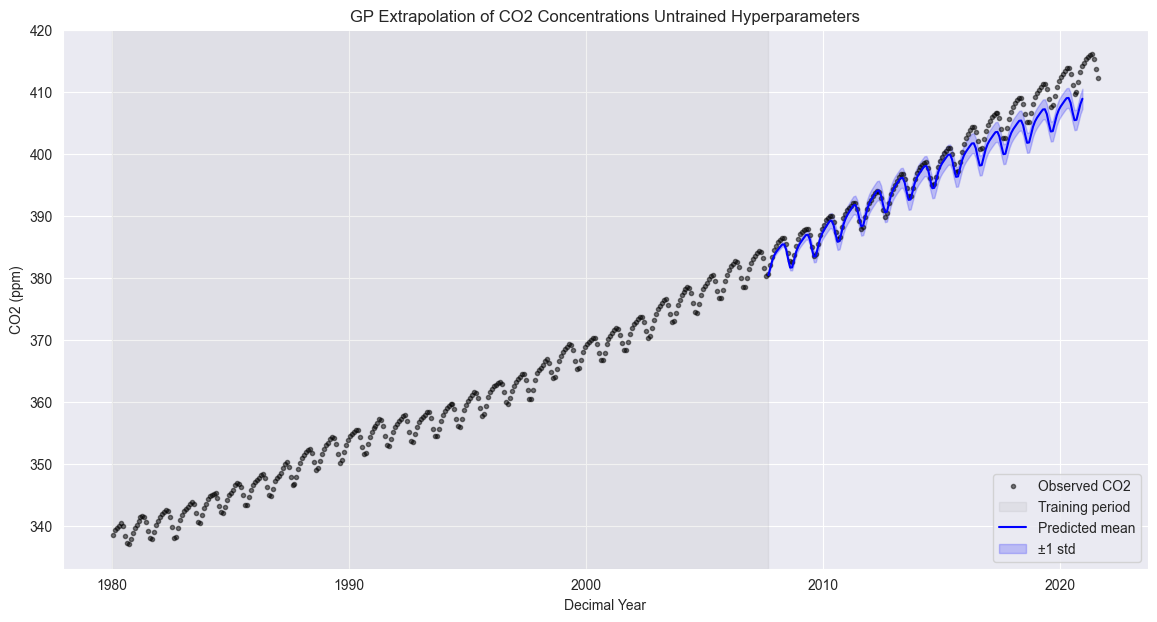

In [7]:
from jax.scipy.linalg import cho_factor, cho_solve


# --- Step 1: Load CO2 data ---

t = []
y = []

# Load data from 'co2.txt'
with open('co2.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if line.startswith('#') or len(line) == 0:
            continue
        parts = line.split()
        if len(parts) >= 5:
            decimal_year = float(parts[2])
            average_co2 = float(parts[3])
            # Shift base year to 1980
            decimal_year -= 1980.0
            t.append(decimal_year)
            y.append(average_co2)

# to JAX arrays
t = jnp.array(t)
y = jnp.array(y)

# --- Step 2: Compute residuals g_obs(t) ---
g_obs = y - (a_posterior * t + b_posterior)

# --- Step 3: Define training and testing sets ---
cutoff = 2007.708 - 1980.0  # 27.708

train_idx = t <= cutoff
test_start = cutoff  # 27.708
test_end = 2020.958 - 1980.0  # 40.958

# Generate monthly intervals from test_start to test_end
num_months = int(round((test_end - test_start) * 12)) + 1  # +1 to include the end
test_t = jnp.linspace(test_start, test_end, num_months)

# Split training data
t_train = t[train_idx]
g_train = g_obs[train_idx]

# --- Step 4: Define the kernel function ---
def kernel(x1, x2, theta, tau, sigma, phi, eta, zeta):
    dist = jnp.pi * (x1[:, None] - x2[None, :]) / tau
    periodic_part = theta**2 * jnp.exp(-2.0 * (jnp.sin(dist)**2) / sigma**2)
    se_part = (theta**2 * phi**2) * jnp.exp(-( (x1[:, None] - x2[None, :])**2 )/(2 * eta**2))

    # Check if x1 and x2 represent the same array
    # Ensure that shapes match and all elements are equal
    same_input = (x1.shape == x2.shape) and bool(jnp.all(x1 == x2))
    noise_part = zeta**2 * jnp.eye(len(x1)) if same_input else 0.0

    return periodic_part + se_part + noise_part

# --- Step 5: Define Hyperparameters ---
# These are fixed as per your requirement
# Choose hyperparameters (untrained):
theta = 3.0   # amplitude of periodic
tau = 1.0   # annual period
sigma = 1.0   # smoothness of periodic part
phi = 0.5   # amplitude of SE part
eta = 2.0    # length-scale of SE part
zeta = 0.2    # noise level

# --- Step 6: Construct Covariance Matrices ---
# Compute training covariance matrix K with noise
K = kernel(t_train, t_train, theta, tau, sigma, phi, eta, zeta)

# Compute cross-covariance matrix K_star between test and train
K_star = kernel(test_t, t_train, theta, tau, sigma, phi, eta, zeta)

# Compute test covariance matrix K_star_star without noise
K_star_star = kernel(test_t, test_t, theta, tau, sigma, phi, eta, zeta)

# --- Step 7: Compute Inverse of K ---
# Perform Cholesky decomposition for numerical stability
L = jnp.linalg.cholesky(K)
# Compute K_inv using Cholesky factors
K_inv = cho_solve((L, True), jnp.eye(len(t_train)))

# --- Step 8: Predictive Mean and Covariance ---
# Predictive mean
g_mean = jnp.dot(K_star, jnp.dot(K_inv, g_train))

# Predictive covariance
# Compute v = L^{-1} K_star^T
v = cho_solve((L, True), K_star.T)
# Compute covariance matrix
g_cov = K_star_star - jnp.dot(K_star, v)
# Standard deviation
g_std = jnp.sqrt(jnp.diag(g_cov))

# --- Step 9: Compute Full CO2 Predictions ---
f_pred = a_posterior * test_t + b_posterior + g_mean

# --- Step 10: Plotting ---
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(t + 1980.0, y, 'k.', alpha=0.5, label='Observed CO2')
plt.axvspan(1980.0, 1980.0 + cutoff, color='gray', alpha=0.1, label='Training period')
plt.plot(test_t + 1980.0, f_pred, 'b-', label='Predicted mean')
plt.fill_between(test_t + 1980.0, f_pred - g_std, f_pred + g_std, color='blue', alpha=0.2, label='±1 std')

plt.title('GP Extrapolation of CO2 Concentrations Untrained Hyperparameters')
plt.xlabel('Decimal Year')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.legend()
plt.savefig("2f1.png", dpi=300)
plt.show()


/var/folders/18/wz5v3z6x7_gdgjx4t9zvjzxc0000gn/T/ipykernel_16561/1564759566.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Optimizing hyperparameters:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration 0, NLL=2294.5719141610507
Iteration 20, NLL=166.08156651619208
Iteration 40, NLL=41.44707405893348
Iteration 60, NLL=24.63212241965323
Iteration 80, NLL=19.09019585937159
Iteration 100, NLL=15.923615476695545
Iteration 120, NLL=13.243397274337724
Iteration 140, NLL=11.084308478476089
Iteration 160, NLL=9.42933367651392
Iteration 180, NLL=8.211619383739162
Optimized Hyperparameters:
theta = 2.684223764172422 tau = 0.9994424051664418 sigma = 1.7570090896549069 phi = 0.6235771688906228 eta = 1.1540795873017244 zeta = 0.1894768957789742


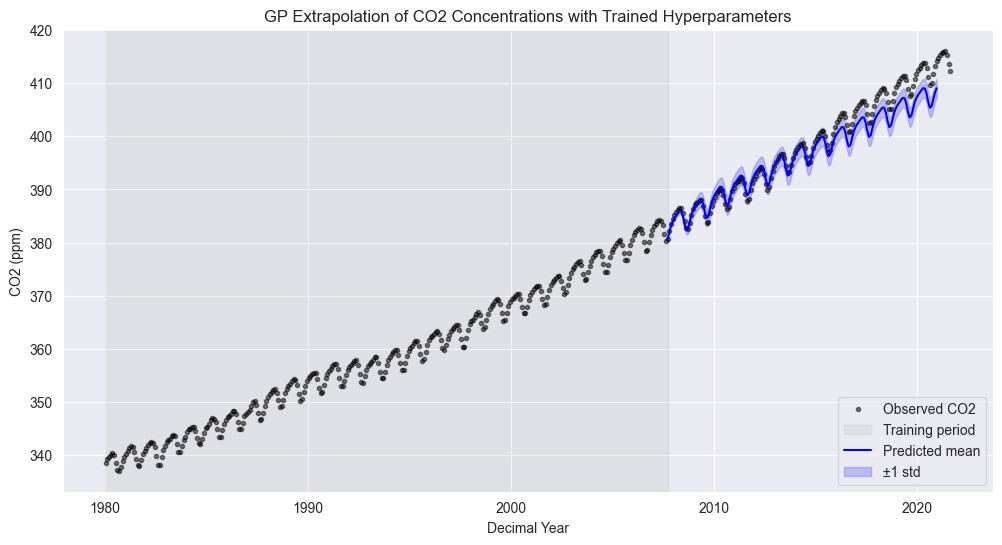

In [6]:
import optax
from tqdm.autonotebook import tqdm


def neg_log_marginal_likelihood(params, X, y):
    # params is a dictionary of raw parameters in log-space
    # Exponentiate to ensure positivity
    theta = jnp.exp(params['log_theta'])
    sigma = jnp.exp(params['log_sigma'])
    phi = jnp.exp(params['log_phi'])
    eta = jnp.exp(params['log_eta'])
    zeta = jnp.exp(params['log_zeta'])
    tau = jnp.exp(params['log_tau'])
    # Construct K
    K = kernel(X, X, theta, tau, sigma, phi, eta, zeta)
    # Add a small jitter for numerical stability
    K += 1e-10 * jnp.eye(len(X))

    # Compute NLL = 0.5*y^T K^-1 y + 0.5 log|K| + n/2 log(2π)
    L = jnp.linalg.cholesky(K)
    # Solve for alpha = K^-1 y using Cholesky
    alpha = jax.scipy.linalg.cho_solve((L, True), y)
    n = len(X)
    nll = 0.5 * y.dot(alpha) + jnp.sum(jnp.log(jnp.diag(L))) + 0.5 * n * jnp.log(2.0 * jnp.pi)
    return nll

# --- Step 4: Setup Optimization ---
# Initial guesses for parameters in log-space
init_params = {
    'log_theta': jnp.log(3.0),
    'log_tau': jnp.log(1.0),
    'log_sigma': jnp.log(1.0),
    'log_phi': jnp.log(0.5),
    'log_eta': jnp.log(2.0),
    'log_zeta': jnp.log(0.2)
}

# Use Adam optimizer from optax
learning_rate = 0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(init_params)

# We can jit the gradient function for efficiency
grad_fn = jax.grad(neg_log_marginal_likelihood)

# --- Step 5: Run Gradient-Based Optimization ---
num_iters = 200
params = init_params
for i in tqdm(range(num_iters), desc="Optimizing hyperparameters"):
    grads = grad_fn(params, t_train, g_train)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if i % 20 == 0:
        current_loss = neg_log_marginal_likelihood(params, t_train, g_train)
        print(f"Iteration {i}, NLL={current_loss}")

# After optimization
opt_theta = jnp.exp(params['log_theta'])
opt_sigma = jnp.exp(params['log_sigma'])
opt_phi = jnp.exp(params['log_phi'])
opt_eta = jnp.exp(params['log_eta'])
opt_zeta = jnp.exp(params['log_zeta'])
opt_tau = jnp.exp(params['log_tau'])

print("Optimized Hyperparameters:")
print("theta =", opt_theta, "tau =", opt_tau, "sigma =", opt_sigma, "phi =", opt_phi, "eta =", opt_eta, "zeta =", opt_zeta)

# --- Step 6: Make Predictions ---
# Suppose we want to predict beyond cutoff
test_start = 2007.708 - 1980.0
test_end = 2020.958 - 1980.0
num_months = int(round((test_end - test_start) * 12)) + 1
test_t = jnp.linspace(test_start, test_end, num_months)

K = kernel(t_train, t_train, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)
K_star = kernel(test_t, t_train, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)
K_star_star = kernel(test_t, test_t, opt_theta, opt_tau, opt_sigma, opt_phi, opt_eta, opt_zeta)

K_inv = jnp.linalg.inv(K)
g_mean = K_star @ K_inv @ g_train
g_cov = K_star_star - K_star @ K_inv @ K_star.T
g_std = jnp.sqrt(jnp.diag(g_cov))

f_pred = a_posterior * test_t + b_posterior + g_mean

# --- Step 7: Plot Results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(t + 1980.0, y, 'k.', alpha=0.5, label='Observed CO2')
plt.axvspan(1980.0, 1980.0 + cutoff, color='gray', alpha=0.1, label='Training period')
plt.plot(test_t + 1980.0, f_pred, 'b-', label='Predicted mean')
plt.fill_between(test_t + 1980.0, f_pred - g_std, f_pred + g_std, color='blue', alpha=0.2, label='±1 std')

plt.title('GP Extrapolation of CO2 Concentrations with Trained Hyperparameters')
plt.xlabel('Decimal Year')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.legend()
plt.savefig("2f2.png", dpi=300)
plt.show()
